In [26]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydaqmx_helper.adc import ADC
from pydaqmx_helper.dac import DAC

In [27]:
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (15,10)

In [28]:
cal_volts = [0,1,2,3,4,5]
cal_freq = [1, 1.355, 1.716, 2.082, 2.443, 2.800]
a, b = np.polyfit(cal_freq, cal_volts, 1)

In [29]:
def volt_freq(freq): #converting voltage
    v = a*freq + b
    return v

In [30]:
myADC = ADC()
myADC.addChannels([0, 1], minRange=0, maxRange=10)

Activated Channel 0
Activated Channel 1


In [31]:
myDAC = DAC(0)
myDAC.writeVoltage(volt_freq(1.4))

In [32]:
def rms_amplitude(x):
    x = np.array(x, dtype=float)
    x = x - np.mean(x)            # removing DC offset
    return np.sqrt(np.mean(x**2))

In [42]:
def measure_at_frequency(f):

    v = volt_freq(f)

    myDAC.writeVoltage(v)
    time.sleep(0.25)

    data = myADC.sampleVoltages(100, 5000)
    ch2 = data[0]
    ch1 = data[1]

    a1 = rms_amplitude(ch1)
    a2 = rms_amplitude(ch2)

    return a1, a2

In [43]:
def run_sweep( out_csv, start_f=1.0, stop_f=2.8, step_f=0.001):

    freqs = np.arange(start_f, stop_f + step_f/2, step_f)

    rows = []
    for f in tqdm(freqs):
        a1, a2 = measure_at_frequency(f)
        rows.append({"f_kHz": f, "A_ch1": a1, "A_ch2": a2})

    df = pd.DataFrame(rows)

    df.to_csv(out_csv)

    plt.figure()
    plt.scatter(df["f_kHz"], df["A_ch1"], label="Channel 1")
    plt.scatter(df["f_kHz"], df["A_ch2"], label="Channel 2")
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Amplitude (V RMS)")
    plt.title("Amplitude vs Frequency")
    plt.grid()
    plt.legend()
    plt.show()

    return df

Name of file Aperture 3 - -Δ 40


100%|██████████████████████████████████████████████████████████████████████████████| 1801/1801 [08:44<00:00,  3.44it/s]


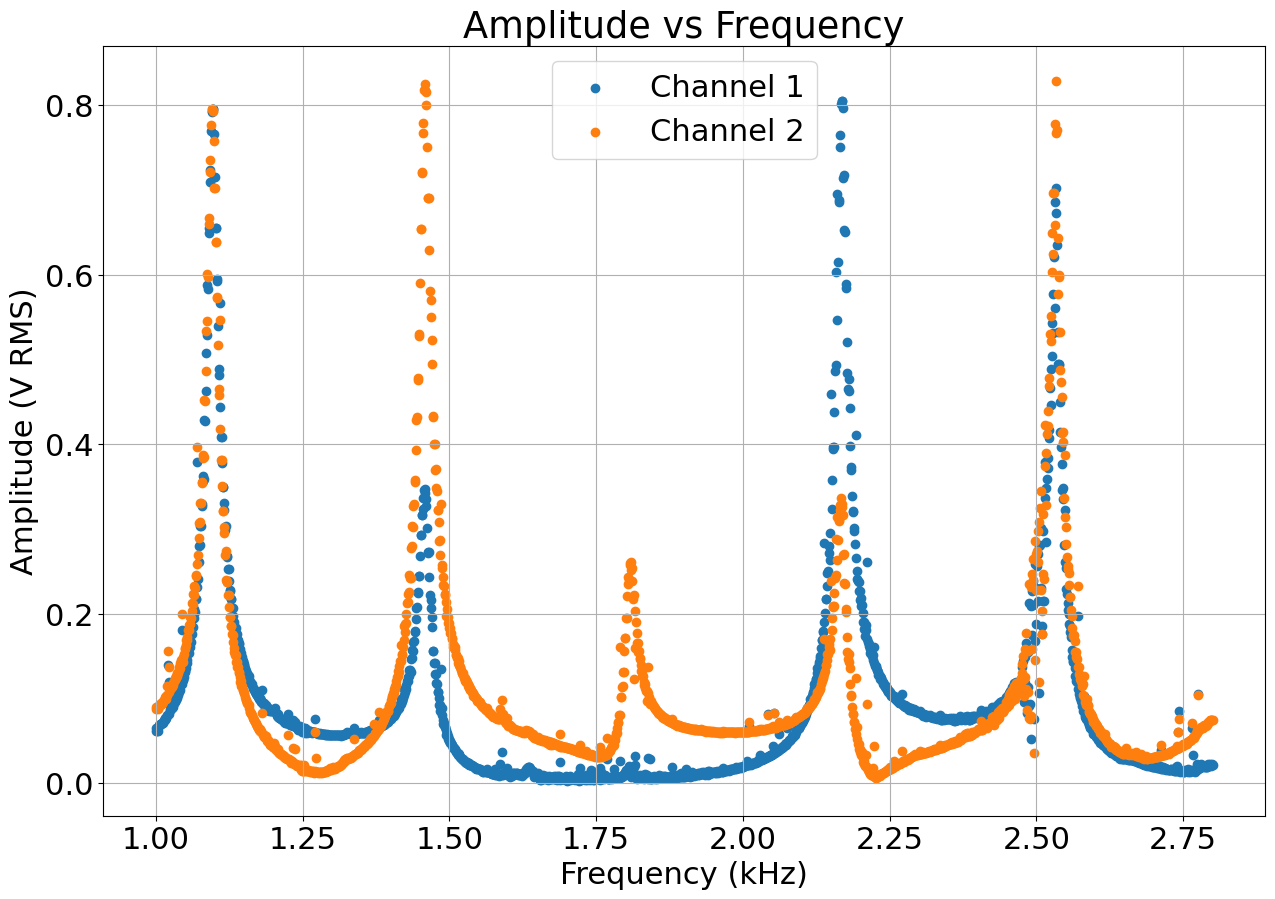

,f_kHz,A_ch1,A_ch2
0,1.000,0.061094,0.087120
1,1.001,0.064343,0.089581
2,1.002,0.061464,0.088211
3,1.003,0.061102,0.087387
4,1.004,0.066390,0.090788
...,...,...,...
1796,2.796,0.022729,0.072858
1797,2.797,0.019966,0.073731
1798,2.798,0.020673,0.073700
1799,2.799,0.022163,0.074339


In [49]:
csv_name = input('Name of file')
run_sweep(csv_name)